In [ ]:
#1
!pip -q install gdown

import os
import io
import pandas as pd

GDRIVE_URL = "https://drive.google.com/file/d/17MsXa86Pe778yn63Z9KDMd9qZfiwpLVQ/view?usp=sharing"

CSV_PATH = "WA_Fn-UseC_-Telco-Customer-Churn.csv"

!gdown --fuzzy "{GDRIVE_URL}" -O "{CSV_PATH}"

df = pd.read_csv(CSV_PATH)
data = df.copy()

print("\n================= BASIC SHAPE =================")
print("Rows (samples):", df.shape[0])
print("Columns (all):", df.shape[1])

target_col = "Churn" if "Churn" in df.columns else None
if target_col is not None:
    print("Target column:", target_col)
    print("Features (excluding target):", df.shape[1] - 1)
else:
    print("Target column 'Churn' not found. Features (all columns):", df.shape[1])

print("\n================= COLUMNS =================")
print(list(df.columns))

print("\n================= DATA.INFO() =================")
buf = io.StringIO()
df.info(buf=buf)
print(buf.getvalue())

print("\n================= MISSING VALUES (NaN) =================")
na_counts = df.isna().sum().sort_values(ascending=False)
na_nonzero = na_counts[na_counts > 0]
print(na_nonzero if len(na_nonzero) else "No NaN values found.")

print("\n================= BLANK/EMPTY STRINGS (OBJECT COLUMNS) =================")
obj_cols = df.select_dtypes(include=["object"]).columns
blank_counts = {}
for c in obj_cols:
    blank_counts[c] = df[c].astype(str).str.strip().eq("").sum()
blank_series = pd.Series(blank_counts).sort_values(ascending=False)
blank_nonzero = blank_series[blank_series > 0]
print(blank_nonzero if len(blank_nonzero) else "No blank strings found in object columns.")

if target_col is not None:
    print("\n================= CLASS DISTRIBUTION (Churn) =================")
    class_counts = df[target_col].value_counts(dropna=False)
    class_percent = (class_counts / len(df) * 100).round(2)
    class_dist = pd.DataFrame({"count": class_counts, "percent": class_percent})
    print(class_dist)

display(df.head())



Downloading...
From: https://drive.google.com/uc?id=17MsXa86Pe778yn63Z9KDMd9qZfiwpLVQ
To: /content/WA_Fn-UseC_-Telco-Customer-Churn.csv
100% 970k/970k [00:00<00:00, 39.9MB/s]

================= BASIC SHAPE =================
Rows (samples): 7043
Columns (all): 21
Target column: Churn
Features (excluding target): 20

================= COLUMNS =================
['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

================= DATA.INFO() =================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender       

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

In [ ]:
#2
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# ----------------------------
# Common preprocessing (ALL scenarios)
# ----------------------------
# Drop useless ID
if "customerID" in df.columns:
    df = df.drop(columns=["customerID"])

# Fix TotalCharges (blank -> NaN -> numeric)
df["TotalCharges"] = df["TotalCharges"].astype(str).str.strip()
df.loc[df["TotalCharges"].eq(""), "TotalCharges"] = np.nan
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# Missing handling: drop rows with NaN (only 11 rows)
before_rows = len(df)
df = df.dropna().copy()
after_rows = len(df)

print("Missing handling:")
print("Rows before:", before_rows, "| Rows after:", after_rows, "| Dropped:", before_rows - after_rows)

y = df["Churn"].map({"Yes": 1, "No": 0})
X = df.drop(columns=["Churn"])

num_cols = ["tenure", "MonthlyCharges", "TotalCharges"]

cat_cols = [c for c in X.columns if c not in num_cols]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

def print_categorical_distributions(X_df, categorical_columns):
    print("\n" + "="*70)
    print("Categorical distributions BEFORE any preprocessing (TRAIN)")
    print("="*70)
    for col in categorical_columns:
        vc = X_df[col].value_counts(dropna=False)
        vp = (vc / len(X_df) * 100).round(2)
        dist = pd.DataFrame({"count": vc, "percent": vp})
        print(f"\n--- {col} ---")
        print(dist.to_string())

print_categorical_distributions(X_train, cat_cols)
print("\nNumeric distribution BEFORE any scaling (TRAIN):")
print(X_train[num_cols].describe().T[["mean", "std", "min", "max"]])

# ----------------------------
#  Helper functions
# ----------------------------
def one_hot_align(train_df, test_df):
    tr = pd.get_dummies(train_df, drop_first=False)
    te = pd.get_dummies(test_df, drop_first=False)
    tr, te = tr.align(te, join="left", axis=1, fill_value=0)
    return tr, te

def iqr_clip(train_df, test_df, cols):
    tr = train_df.copy()
    te = test_df.copy()
    bounds = {}

    for c in cols:
        q1 = tr[c].quantile(0.25)
        q3 = tr[c].quantile(0.75)
        iqr = q3 - q1
        low = q1 - 1.5 * iqr
        high = q3 + 1.5 * iqr
        bounds[c] = (low, high)

        tr[c] = tr[c].clip(low, high)
        te[c] = te[c].clip(low, high)

    return tr, te, bounds

def scale_numeric(train_df, test_df, cols, method):
    tr = train_df.copy()
    te = test_df.copy()

    if method == "standard":
        scaler = StandardScaler()
    elif method == "minmax":
        scaler = MinMaxScaler()
    else:
        raise ValueError("method must be 'standard' or 'minmax'")

    tr[cols] = scaler.fit_transform(tr[cols])
    te[cols] = scaler.transform(te[cols])

    return tr, te

def evaluate_model(Xtr, Xte, ytr, yte):
    model = LogisticRegression(max_iter=3000, solver="liblinear", random_state=42)
    model.fit(Xtr, ytr)

    pred = model.predict(Xte)
    prob = model.predict_proba(Xte)[:, 1]

    return {
        "accuracy": accuracy_score(yte, pred),
        "precision": precision_score(yte, pred, zero_division=0),
        "recall": recall_score(yte, pred, zero_division=0),
        "f1": f1_score(yte, pred, zero_division=0),
        "roc_auc": roc_auc_score(yte, prob),
    }

def run_scenario(name, scale_method, use_outliers):
    tr = X_train.copy()
    te = X_test.copy()

    # Outlier handling
    bounds = None
    if use_outliers:
        tr, te, bounds = iqr_clip(tr, te, num_cols)

    # Scaling
    tr, te = scale_numeric(tr, te, num_cols, scale_method)

    # One-hot encoding
    tr_enc, te_enc = one_hot_align(tr, te)

    # Distribution AFTER preprocessing (numeric only)
    num_dist = tr[num_cols].describe().T[["mean", "std", "min", "max"]]

    # One-hot distribution idea: show top 10 most frequent binary features
    cat_features = [c for c in tr_enc.columns if c not in num_cols]
    top10 = (tr_enc[cat_features].mean().sort_values(ascending=False).head(10) * 100)

    metrics = evaluate_model(tr_enc, te_enc, y_train, y_test)

    print("\n" + "="*65)
    print("Scenario:", name)
    if bounds is not None:
        print("\nOutlier bounds (computed on TRAIN, IQR method):")
        for k, (lo, hi) in bounds.items():
            print(f"{k}: low={lo:.3f}, high={hi:.3f}")

    print("\nNumeric distribution AFTER preprocessing (TRAIN):")
    print(num_dist)

    print("\nTop 10 most frequent one-hot features (TRAIN) [%]:")
    print(top10.round(2).to_string())

    print("\nModel performance (TEST):")
    print(pd.DataFrame([metrics]).to_string(index=False))

    return {"scenario": name, **metrics, "n_features_after_onehot": tr_enc.shape[1]}
results = []
results.append(run_scenario("S1) Standardization ", scale_method="standard", use_outliers=False))
results.append(run_scenario("S2) Normalization ", scale_method="minmax", use_outliers=False))
results.append(run_scenario("S3) Outlier(IQR) + Standardization", scale_method="standard", use_outliers=True))
results.append(run_scenario("S4) Outlier(IQR) + Normalization", scale_method="minmax", use_outliers=True))

final_df = pd.DataFrame(results).sort_values("roc_auc", ascending=False)
print("\n" + "="*65)
print("FINAL COMPARISON (sorted by ROC-AUC):")
print(final_df.to_string(index=False))



Missing handling:
Rows before: 7043 | Rows after: 7032 | Dropped: 11

Categorical distributions BEFORE any preprocessing (TRAIN)

--- gender ---
        count  percent
gender                
Male     2823    50.19
Female   2802    49.81

--- SeniorCitizen ---
               count  percent
SeniorCitizen                
0               4715    83.82
1                910    16.18

--- Partner ---
         count  percent
Partner                
No        2891     51.4
Yes       2734     48.6

--- Dependents ---
            count  percent
Dependents                
No           3940    70.04
Yes          1685    29.96

--- PhoneService ---
              count  percent
PhoneService                
Yes            5080    90.31
No              545     9.69

--- MultipleLines ---
                  count  percent
MultipleLines                   
No                 2695    47.91
Yes                2385    42.40
No phone service    545     9.69

--- InternetService ---
                 count  perc

In [ ]:
#3
import numpy as np
import pandas as pd
from time import perf_counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE

if "customerID" in data.columns:
    data = data.drop(columns=["customerID"])

if "TotalCharges" in data.columns:
    data["TotalCharges"] = data["TotalCharges"].astype(str).str.strip()
    data.loc[data["TotalCharges"].eq(""), "TotalCharges"] = np.nan
    data["TotalCharges"] = pd.to_numeric(data["TotalCharges"], errors="coerce")

data = data.dropna().copy()

y = data["Churn"].map({"Yes": 1, "No": 0})
X = data.drop(columns=["Churn"])

X = pd.get_dummies(X, drop_first=False)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

def run_method(method_name):
    t0 = perf_counter()

    scaler = StandardScaler()
    Xtr_s = scaler.fit_transform(X_train.values)
    Xte_s = scaler.transform(X_test.values)

    reducer = None

    if method_name == "Baseline":
        Xtr_r = Xtr_s
        Xte_r = Xte_s

    elif method_name == "PCA":
        reducer = PCA(n_components=0.99, random_state=42)
        Xtr_r = reducer.fit_transform(Xtr_s)
        Xte_r = reducer.transform(Xte_s)

    elif method_name == "LDA":
        reducer = LinearDiscriminantAnalysis(n_components=1)
        Xtr_r = reducer.fit_transform(Xtr_s, y_train.values)
        Xte_r = reducer.transform(Xte_s)

    elif method_name == "t-SNE":
        reducer = TSNE(
            n_components=2,
            perplexity=30,
            learning_rate="auto",
            init="pca",
            random_state=42
        )
        X_all = np.vstack([Xtr_s, Xte_s])
        X_all_emb = reducer.fit_transform(X_all)
        Xtr_r = X_all_emb[:len(X_train)]
        Xte_r = X_all_emb[len(X_train):]

    else:
        raise ValueError("Unknown method")

    model = LogisticRegression(max_iter=3000, solver="liblinear", random_state=42)
    model.fit(Xtr_r, y_train.values)

    fit_time = perf_counter() - t0

    t1 = perf_counter()

    if method_name in ["Baseline", "PCA", "LDA"]:
        Xte_s2 = scaler.transform(X_test.values)
        if method_name == "Baseline":
            Xte_final = Xte_s2
        elif method_name == "PCA":
            Xte_final = reducer.transform(Xte_s2)
        elif method_name == "LDA":
            Xte_final = reducer.transform(Xte_s2)

    elif method_name == "t-SNE":
        Xte_final = Xte_r

    proba = model.predict_proba(Xte_final)[:, 1]
    pred = (proba >= 0.5).astype(int)

    inference_time = perf_counter() - t1

    acc = accuracy_score(y_test.values, pred)
    f1 = f1_score(y_test.values, pred)
    auc = roc_auc_score(y_test.values, proba)

    return {
        "method": method_name,
        "n_features_after": int(Xtr_r.shape[1]),
        "fit_time_sec": float(fit_time),
        "inference_time_sec": float(inference_time),
        "accuracy": float(acc),
        "f1": float(f1),
        "roc_auc": float(auc),
    }

results = []
for m in ["Baseline", "PCA", "LDA", "t-SNE"]:
    results.append(run_method(m))

results_df = pd.DataFrame(results).sort_values("roc_auc", ascending=False)

display(results_df)



method  n_features_after  fit_time_sec  inference_time_sec  accuracy  \
0  Baseline                45      0.362666            0.042262  0.803838   
1       PCA                20      0.226679            0.016955  0.798152   
2       LDA                 1      0.292229            0.009071  0.794598   
3     t-SNE                 2    104.750217            0.000468  0.738451   

         f1   roc_auc  
0  0.609065  0.835564  
1  0.600000  0.828757  
2  0.582973  0.828286  
3  0.361111  0.740901

In [ ]:
#4
import numpy as np
import pandas as pd
from time import perf_counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

if "customerID" in data.columns:
    data = data.drop(columns=["customerID"])

if "TotalCharges" in data.columns:
    data["TotalCharges"] = data["TotalCharges"].astype(str).str.strip()
    data.loc[data["TotalCharges"].eq(""), "TotalCharges"] = np.nan
    data["TotalCharges"] = pd.to_numeric(data["TotalCharges"], errors="coerce")

if "SeniorCitizen" in data.columns:
    data["SeniorCitizen"] = data["SeniorCitizen"].astype(str)

data = data.dropna().copy()

y = data["Churn"].map({"Yes": 1, "No": 0})
X = data.drop(columns=["Churn"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train_ohe = pd.get_dummies(X_train, drop_first=False)
X_test_ohe  = pd.get_dummies(X_test, drop_first=False)
X_train_ohe, X_test_ohe = X_train_ohe.align(X_test_ohe, join="left", axis=1, fill_value=0)

scaler = StandardScaler()
pca = PCA(n_components=0.99, random_state=42)

t0 = perf_counter()
Xtr_scaled = scaler.fit_transform(X_train_ohe)
Xtr_pca = pca.fit_transform(Xtr_scaled)
prep_fit_time = perf_counter() - t0

n_features_after = Xtr_pca.shape[1]
print("n_features_after (PCA):", n_features_after)

def eval_model(model_name, model):
    t0 = perf_counter()
    model.fit(Xtr_pca, y_train)
    model_fit_time = perf_counter() - t0

    t1 = perf_counter()
    Xte_scaled = scaler.transform(X_test_ohe)
    Xte_pca = pca.transform(Xte_scaled)

    if hasattr(model, "predict_proba"):
        scores = model.predict_proba(Xte_pca)[:, 1]
        pred = (scores >= 0.5).astype(int)
        roc_input = scores
    else:
        scores = model.decision_function(Xte_pca)
        pred = (scores >= 0).astype(int)
        roc_input = scores

    inference_time = perf_counter() - t1

    return {
        "model": model_name,
        "n_features_after": n_features_after,
        "fit_time_sec": prep_fit_time + model_fit_time,
        "inference_time_sec": inference_time,
        "accuracy": accuracy_score(y_test, pred),
        "f1": f1_score(y_test, pred),
        "roc_auc": roc_auc_score(y_test, roc_input),
    }

results = []

lr = LogisticRegression(
    max_iter=3000,
    solver="liblinear",
    random_state=42,
    class_weight="balanced"
)
results.append(eval_model("LogisticRegression + PCA", lr))

svm = LinearSVC(
    random_state=42,
    class_weight="balanced"
)
results.append(eval_model("LinearSVM + PCA", svm))

dt = DecisionTreeClassifier(
    random_state=42,
    class_weight="balanced",
    max_depth=None
)
results.append(eval_model("DecisionTree + PCA", dt))

results_df = pd.DataFrame(results).sort_values("roc_auc", ascending=False)
display(results_df)



n_features_after (PCA): 20


model  n_features_after  fit_time_sec  \
0  LogisticRegression + PCA                20      0.176207   
1           LinearSVM + PCA                20      0.175422   
2        DecisionTree + PCA                20      0.759194   

   inference_time_sec  accuracy        f1   roc_auc  
0            0.019198  0.722814  0.600410  0.828198  
1            0.019794  0.719972  0.600406  0.828014  
2            0.013704  0.705046  0.460338  0.631290

In [ ]:
#5
!pip -q install optuna
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_score
import optuna
from optuna.samplers import TPESampler
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def save_cv_results(cv_results, filename):
    df2 = pd.DataFrame(cv_results)[["mean_test_score", "std_test_score", "rank_test_score", "params"]]
    df2 = df2.sort_values("rank_test_score")
    df2.to_csv(filename, index=False)
    print("Saved:", filename, "| rows:", len(df2))

def build_model(model_key, params):
    if model_key == "LogisticRegression":
        m = LogisticRegression(max_iter=3000, solver="liblinear", random_state=42)
    elif model_key == "LinearSVM":
        m = LinearSVC(random_state=42, max_iter=5000)
    elif model_key == "DecisionTree":
        m = DecisionTreeClassifier(random_state=42)
    else:
        raise ValueError("Unknown model key")

    m.set_params(**params)
    return m


grid_spaces = {
    "LogisticRegression": {
        "C": [0.01, 0.1, 1, 10, 100],
        "penalty": ["l1", "l2"],
        "class_weight": [None, "balanced"]
    },
    "LinearSVM": {
        "C": [0.01, 0.1, 1, 10, 100],
        "class_weight": [None, "balanced"]
    },
    "DecisionTree": {
        "criterion": ["gini", "entropy"],
        "max_depth": [None, 5, 10],
        "min_samples_split": [2, 10],
        "min_samples_leaf": [1, 5],
        "class_weight": [None, "balanced"]
    }
}

random_spaces = {
    "LogisticRegression": {
        "C": list(np.logspace(-3, 2, 25)),
        "penalty": ["l1", "l2"],
        "class_weight": [None, "balanced"]
    },
    "LinearSVM": {
        "C": list(np.logspace(-3, 2, 25)),
        "class_weight": [None, "balanced"]
    },
    "DecisionTree": {
        "criterion": ["gini", "entropy"],
        "max_depth": [None, 3, 5, 8, 12],
        "min_samples_split": [2, 5, 10, 20, 40],
        "min_samples_leaf": [1, 2, 5, 10, 20],
        "class_weight": [None, "balanced"]
    }
}

models_base = {
    "LogisticRegression": LogisticRegression(max_iter=3000, solver="liblinear", random_state=42),
    "LinearSVM": LinearSVC(random_state=42, max_iter=5000),
    "DecisionTree": DecisionTreeClassifier(random_state=42)
}

best_summary = []
final_models_results = []


for model_key in ["LogisticRegression", "LinearSVM", "DecisionTree"]:
    print("\n" + "="*80)
    print("TUNING MODEL:", model_key)
    print("="*80)

    # ---------------- GRID SEARCH ----------------
    print("\nGRID SEARCH SPACE:")
    for k, v in grid_spaces[model_key].items():
        print(k, "->", v)

    gs = GridSearchCV(
        estimator=models_base[model_key],
        param_grid=grid_spaces[model_key],
        scoring="roc_auc",
        cv=cv,
        n_jobs=-1,
        refit=True
    )

    t0 = perf_counter()
    gs.fit(Xtr_pca, y_train)
    t1 = perf_counter()

    print("Grid best CV roc_auc:", gs.best_score_)
    print("Grid best params:", gs.best_params_)
    print("Grid time (sec):", round(t1 - t0, 3))

    save_cv_results(gs.cv_results_, f"grid_{model_key}.csv")

    best_summary.append({
        "model": model_key,
        "search": "GridSearch",
        "best_cv_roc_auc": gs.best_score_,
        "best_params": gs.best_params_
    })

    best_g = build_model(model_key, gs.best_params_)
    final_models_results.append(eval_model(f"{model_key} + PCA | Grid best", best_g))


    # ---------------- RANDOM SEARCH ----------------
    print("\nRANDOM SEARCH SPACE:")
    for k, v in random_spaces[model_key].items():
        if isinstance(v, list) and len(v) > 12:
            print(k, "->", f"list(len={len(v)}) sample:", v[:5], "...", v[-3:])
        else:
            print(k, "->", v)

    rs = RandomizedSearchCV(
        estimator=models_base[model_key],
        param_distributions=random_spaces[model_key],
        n_iter=20,
        scoring="roc_auc",
        cv=cv,
        n_jobs=-1,
        refit=True,
        random_state=42
    )

    t0 = perf_counter()
    rs.fit(Xtr_pca, y_train)
    t1 = perf_counter()

    print("Random best CV roc_auc:", rs.best_score_)
    print("Random best params:", rs.best_params_)
    print("Random time (sec):", round(t1 - t0, 3))

    save_cv_results(rs.cv_results_, f"random_{model_key}.csv")

    best_summary.append({
        "model": model_key,
        "search": "RandomSearch",
        "best_cv_roc_auc": rs.best_score_,
        "best_params": rs.best_params_
    })

    best_r = build_model(model_key, rs.best_params_)
    final_models_results.append(eval_model(f"{model_key} + PCA | Random best", best_r))


    # ---------------- OPTUNA ----------------
    print("\nOPTUNA SEARCH SPACE:")
    if model_key in ["LogisticRegression", "LinearSVM"]:
        print("C: log float in [1e-3, 1e2]")
        print("class_weight: [None, 'balanced']")
        if model_key == "LogisticRegression":
            print("penalty: ['l1','l2']")
    else:
        print("criterion: ['gini','entropy']")
        print("max_depth: [None,3,5,8,12]  categorical")
        print("min_samples_split: int in [2,40]")
        print("min_samples_leaf: int in [1,20]")
        print("class_weight: [None, 'balanced']")

    def objective(trial):
        if model_key == "LogisticRegression":
            params = {
                "C": trial.suggest_float("C", 1e-3, 1e2, log=True),
                "penalty": trial.suggest_categorical("penalty", ["l1", "l2"]),
                "class_weight": trial.suggest_categorical("class_weight", [None, "balanced"])
            }
            m = LogisticRegression(max_iter=3000, solver="liblinear", random_state=42, **params)

        elif model_key == "LinearSVM":
            params = {
                "C": trial.suggest_float("C", 1e-3, 1e2, log=True),
                "class_weight": trial.suggest_categorical("class_weight", [None, "balanced"])
            }
            m = LinearSVC(random_state=42, max_iter=5000, **params)

        else:
            params = {
                "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
                "max_depth": trial.suggest_categorical("max_depth", [None, 3, 5, 8, 12]),
                "min_samples_split": trial.suggest_int("min_samples_split", 2, 40),
                "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
                "class_weight": trial.suggest_categorical("class_weight", [None, "balanced"])
            }
            m = DecisionTreeClassifier(random_state=42, **params)

        score = cross_val_score(m, Xtr_pca, y_train, scoring="roc_auc", cv=cv, n_jobs=-1).mean()
        return score
    sampler = TPESampler(seed=42)
    study = optuna.create_study(direction="maximize", sampler=sampler)
    t0 = perf_counter()
    study.optimize(objective, n_trials=20, show_progress_bar=False)
    t1 = perf_counter()

    print("Optuna best CV roc_auc:", study.best_value)
    print("Optuna best params:", study.best_trial.params)
    print("Optuna time (sec):", round(t1 - t0, 3))

    trials_df = study.trials_dataframe()
    trials_df.to_csv(f"optuna_{model_key}.csv", index=False)
    print("Saved:", f"optuna_{model_key}.csv", "| rows:", len(trials_df))

    best_summary.append({
        "model": model_key,
        "search": "Optuna",
        "best_cv_roc_auc": study.best_value,
        "best_params": study.best_trial.params
    })

    best_o = build_model(model_key, study.best_trial.params)
    final_models_results.append(eval_model(f"{model_key} + PCA | Optuna best", best_o))


best_params_df = pd.DataFrame(best_summary)
final_compare_df = pd.DataFrame(final_models_results).sort_values("roc_auc", ascending=False)

print("\n" + "="*80)
print("BEST PARAMS SUMMARY (CV)")
print("="*80)
print(best_params_df.to_string(index=False))

print("\n" + "="*80)
print("FINAL TEST COMPARISON (sorted by roc_auc)")
print("="*80)
print(final_compare_df.to_string(index=False))

best_params_df.to_csv("best_params_summary.csv", index=False)
final_compare_df.to_csv("final_test_comparison.csv", index=False)

print("\nSaved: best_params_summary.csv")
print("Saved: final_test_comparison.csv")

print("\nAlso saved per-model full results:")
print("grid_<Model>.csv , random_<Model>.csv , optuna_<Model>.csv")




TUNING MODEL: LogisticRegression

GRID SEARCH SPACE:
C -> [0.01, 0.1, 1, 10, 100]
penalty -> ['l1', 'l2']
class_weight -> [None, 'balanced']
Grid best CV roc_auc: 0.8423194344343938
Grid best params: {'C': 0.1, 'class_weight': None, 'penalty': 'l1'}
Grid time (sec): 3.005
Saved: grid_LogisticRegression.csv | rows: 20

RANDOM SEARCH SPACE:
C -> list(len=25) sample: [np.float64(0.001), np.float64(0.0016155980984398745), np.float64(0.0026101572156825357), np.float64(0.004216965034285823), np.float64(0.006812920690579615)] ... [np.float64(38.31186849557293), np.float64(61.8965818891261), np.float64(100.0)]
penalty -> ['l1', 'l2']
class_weight -> [None, 'balanced']


[I 2026-02-13 01:49:50,815] A new study created in memory with name: no-name-1d6c2988-85c4-4a27-9a6a-e3140aa0aa96


Random best CV roc_auc: 0.8423121462178205
Random best params: {'penalty': 'l1', 'class_weight': None, 'C': np.float64(0.19573417814876617)}
Random time (sec): 4.105
Saved: random_LogisticRegression.csv | rows: 20

OPTUNA SEARCH SPACE:
C: log float in [1e-3, 1e2]
class_weight: [None, 'balanced']
penalty: ['l1','l2']


[I 2026-02-13 01:49:51,028] Trial 0 finished with value: 0.8422991893883566 and parameters: {'C': 0.0745934328572655, 'penalty': 'l1', 'class_weight': None}. Best is trial 0 with value: 0.8422991893883566.
[I 2026-02-13 01:49:51,166] Trial 1 finished with value: 0.8416553969243725 and parameters: {'C': 0.0060252157362038605, 'penalty': 'l2', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.8422991893883566.
[I 2026-02-13 01:49:51,282] Trial 2 finished with value: 0.7955080291852583 and parameters: {'C': 0.001267425589893723, 'penalty': 'l1', 'class_weight': None}. Best is trial 0 with value: 0.8422991893883566.
[I 2026-02-13 01:49:51,441] Trial 3 finished with value: 0.8410593827690365 and parameters: {'C': 0.008260808399079604, 'penalty': 'l2', 'class_weight': None}. Best is trial 0 with value: 0.8422991893883566.
[I 2026-02-13 01:49:51,749] Trial 4 finished with value: 0.8419056256933928 and parameters: {'C': 1.1462107403425035, 'penalty': 'l2', 'class_weight': 'balanced'}.

Optuna best CV roc_auc: 0.8422991893883566
Optuna best params: {'C': 0.0745934328572655, 'penalty': 'l1', 'class_weight': None}
Optuna time (sec): 4.029
Saved: optuna_LogisticRegression.csv | rows: 20

TUNING MODEL: LinearSVM

GRID SEARCH SPACE:
C -> [0.01, 0.1, 1, 10, 100]
class_weight -> [None, 'balanced']
Grid best CV roc_auc: 0.8416132872286152
Grid best params: {'C': 100, 'class_weight': 'balanced'}
Grid time (sec): 1.326
Saved: grid_LinearSVM.csv | rows: 10

RANDOM SEARCH SPACE:
C -> list(len=25) sample: [np.float64(0.001), np.float64(0.0016155980984398745), np.float64(0.0026101572156825357), np.float64(0.004216965034285823), np.float64(0.006812920690579615)] ... [np.float64(38.31186849557293), np.float64(61.8965818891261), np.float64(100.0)]
class_weight -> [None, 'balanced']


[I 2026-02-13 01:49:59,194] A new study created in memory with name: no-name-8773d417-ee29-4986-8936-057469310802


Random best CV roc_auc: 0.8416132872286152
Random best params: {'class_weight': 'balanced', 'C': np.float64(5.623413251903491)}
Random time (sec): 2.744
Saved: random_LinearSVM.csv | rows: 20

OPTUNA SEARCH SPACE:
C: log float in [1e-3, 1e2]
class_weight: [None, 'balanced']


[I 2026-02-13 01:49:59,390] Trial 0 finished with value: 0.8402252868723024 and parameters: {'C': 0.0745934328572655, 'class_weight': None}. Best is trial 0 with value: 0.8402252868723024.
[I 2026-02-13 01:49:59,569] Trial 1 finished with value: 0.8402463417201812 and parameters: {'C': 0.9846738873614566, 'class_weight': None}. Best is trial 1 with value: 0.8402463417201812.
[I 2026-02-13 01:49:59,827] Trial 2 finished with value: 0.8393199284135171 and parameters: {'C': 0.0019517224641449498, 'class_weight': None}. Best is trial 1 with value: 0.8402463417201812.
[I 2026-02-13 01:50:00,057] Trial 3 finished with value: 0.8416140970304566 and parameters: {'C': 3.4702669886504163, 'class_weight': 'balanced'}. Best is trial 3 with value: 0.8416140970304566.
[I 2026-02-13 01:50:00,243] Trial 4 finished with value: 0.8402503907293886 and parameters: {'C': 14.528246637516036, 'class_weight': None}. Best is trial 3 with value: 0.8416140970304566.
[I 2026-02-13 01:50:00,540] Trial 5 finished w

Optuna best CV roc_auc: 0.8416173362378228
Optuna best params: {'C': 0.004982752357076452, 'class_weight': 'balanced'}
Optuna time (sec): 4.945
Saved: optuna_LinearSVM.csv | rows: 20

TUNING MODEL: DecisionTree

GRID SEARCH SPACE:
criterion -> ['gini', 'entropy']
max_depth -> [None, 5, 10]
min_samples_split -> [2, 10]
min_samples_leaf -> [1, 5]
class_weight -> [None, 'balanced']
Grid best CV roc_auc: 0.8029379610809235
Grid best params: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2}
Grid time (sec): 34.341
Saved: grid_DecisionTree.csv | rows: 48

RANDOM SEARCH SPACE:
criterion -> ['gini', 'entropy']
max_depth -> [None, 3, 5, 8, 12]
min_samples_split -> [2, 5, 10, 20, 40]
min_samples_leaf -> [1, 2, 5, 10, 20]
class_weight -> [None, 'balanced']


[I 2026-02-13 01:50:50,029] A new study created in memory with name: no-name-d3dba24b-ea79-404c-849f-284ca63d8293


Random best CV roc_auc: 0.8036935061990331
Random best params: {'min_samples_split': 5, 'min_samples_leaf': 10, 'max_depth': 5, 'criterion': 'gini', 'class_weight': 'balanced'}
Random time (sec): 11.223
Saved: random_DecisionTree.csv | rows: 20

OPTUNA SEARCH SPACE:
criterion: ['gini','entropy']
max_depth: [None,3,5,8,12]  categorical
min_samples_split: int in [2,40]
min_samples_leaf: int in [1,20]
class_weight: [None, 'balanced']


[I 2026-02-13 01:50:50,784] Trial 0 finished with value: 0.7601237377213795 and parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 35, 'min_samples_leaf': 13, 'class_weight': None}. Best is trial 0 with value: 0.7601237377213795.
[I 2026-02-13 01:50:51,430] Trial 1 finished with value: 0.7146043713103405 and parameters: {'criterion': 'gini', 'max_depth': 12, 'min_samples_split': 18, 'min_samples_leaf': 6, 'class_weight': None}. Best is trial 0 with value: 0.7601237377213795.
[I 2026-02-13 01:50:51,731] Trial 2 finished with value: 0.7867467830621847 and parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 13, 'class_weight': None}. Best is trial 2 with value: 0.7867467830621847.
[I 2026-02-13 01:50:52,487] Trial 3 finished with value: 0.7527419890352831 and parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 6, 'min_samples_leaf': 10, 'class_weight': 'balanced'}. Best is trial 2 with value: 0

Optuna best CV roc_auc: 0.8048341120927709
Optuna best params: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 24, 'min_samples_leaf': 8, 'class_weight': 'balanced'}
Optuna time (sec): 11.102
Saved: optuna_DecisionTree.csv | rows: 20

BEST PARAMS SUMMARY (CV)
             model       search  best_cv_roc_auc                                                                                                       best_params
LogisticRegression   GridSearch         0.842319                                                                 {'C': 0.1, 'class_weight': None, 'penalty': 'l1'}
LogisticRegression RandomSearch         0.842312                                                 {'penalty': 'l1', 'class_weight': None, 'C': 0.19573417814876617}
LogisticRegression       Optuna         0.842299                                                  {'C': 0.0745934328572655, 'penalty': 'l1', 'class_weight': None}
         LinearSVM   GridSearch         0.841613                             


================= FINAL METRICS (TEST) =================
             model  accuracy  precision   recall       f1  roc_auc  avg_precision
LogisticRegression  0.800284   0.641337 0.564171 0.600284 0.828739       0.606837
         LinearSVM  0.719261   0.482871 0.791444 0.599797 0.827882       0.606251
      DecisionTree  0.701493   0.465152 0.820856 0.593810 0.787594       0.525024

Saved: final_metrics_after_tuning.csv


<Figure size 640x480 with 0 Axes>

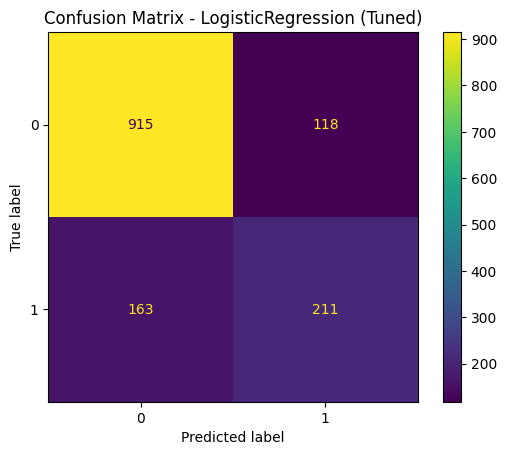

<Figure size 640x480 with 0 Axes>

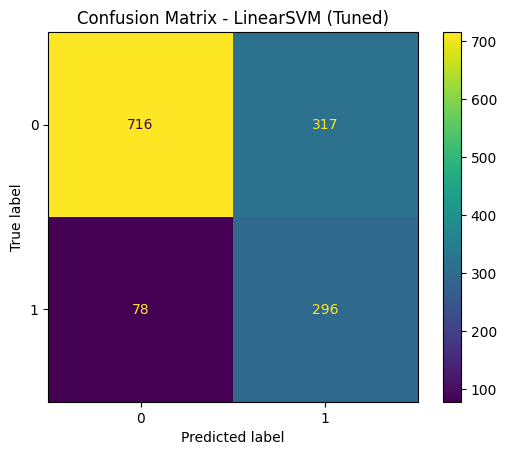

<Figure size 640x480 with 0 Axes>

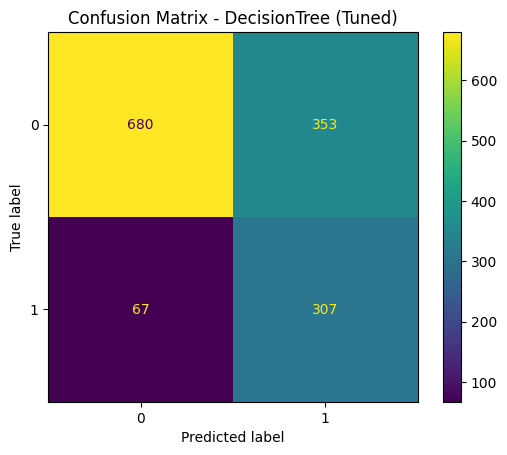

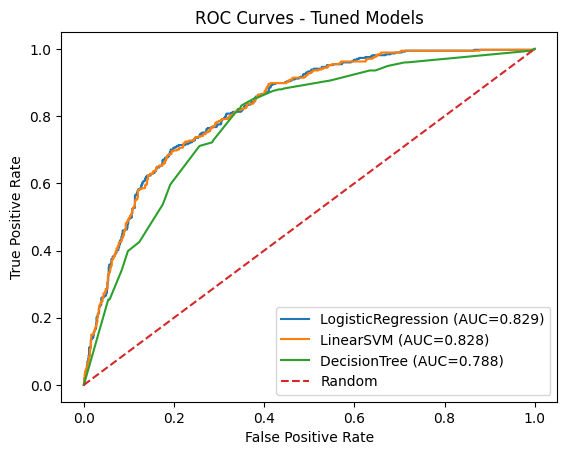

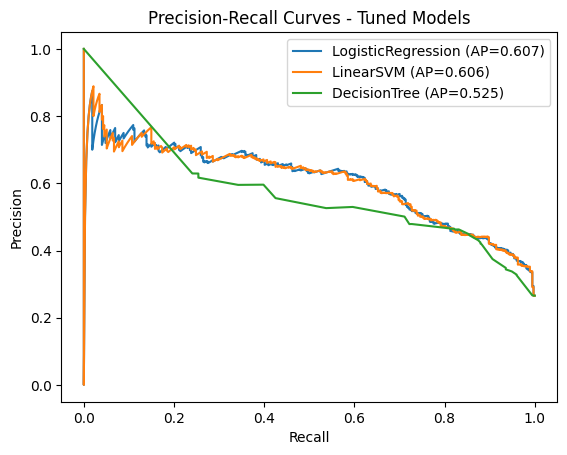

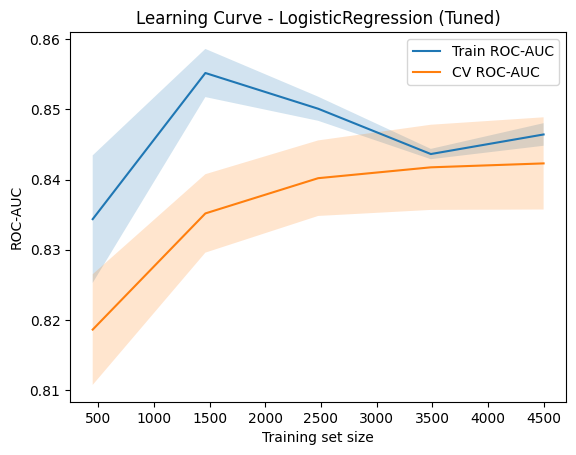

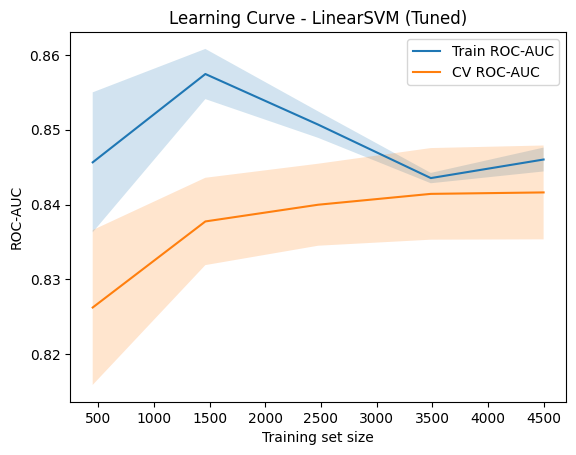

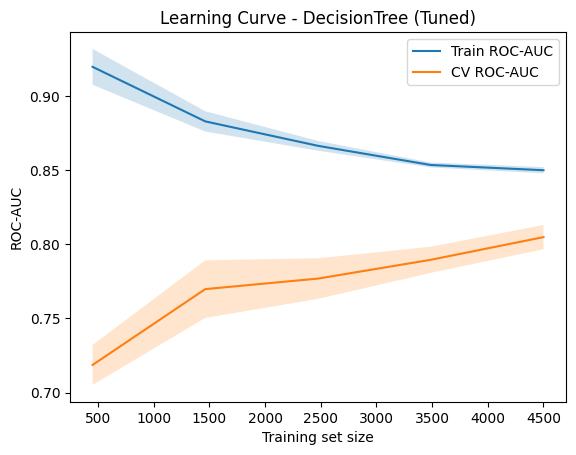

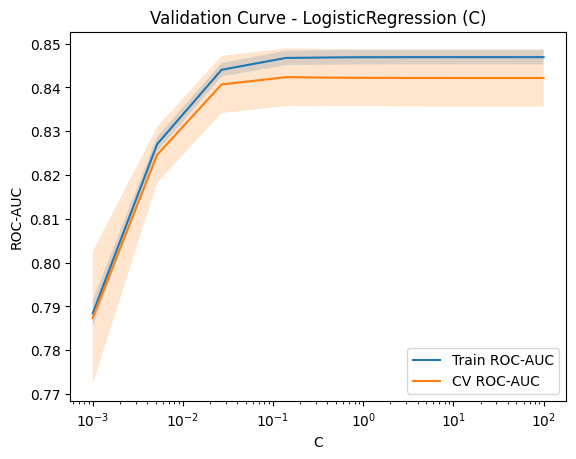

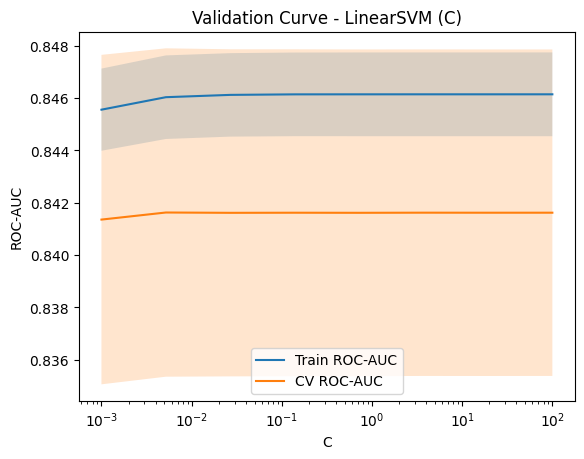

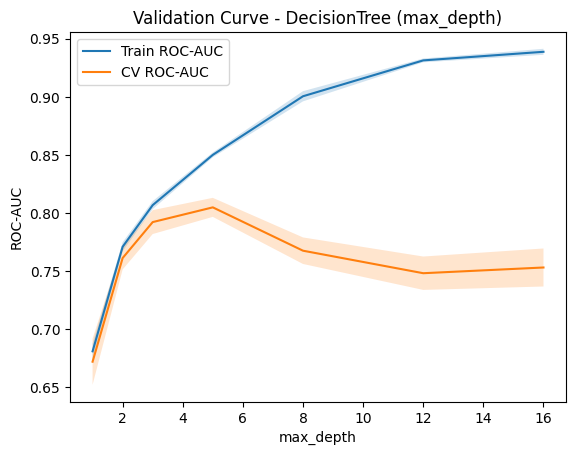

In [ ]:
#7
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, precision_recall_curve, average_precision_score
)

from sklearn.model_selection import StratifiedKFold, learning_curve, validation_curve

best_params = {
    "LogisticRegression": {"C": 0.0745934328572655, "penalty": "l1", "class_weight": None},
    "LinearSVM":          {"C": 0.004982752357076452, "class_weight": "balanced"},
    "DecisionTree":       {"criterion": "gini", "max_depth": 5, "min_samples_split": 24,
                           "min_samples_leaf": 8, "class_weight": "balanced"}
}

Xte_scaled = scaler.transform(X_test_ohe)
Xte_pca = pca.transform(Xte_scaled)

def get_pred_and_score(model, X):
    if hasattr(model, "predict_proba"):
        score = model.predict_proba(X)[:, 1]
        pred = (score >= 0.5).astype(int)
    else:
        score = model.decision_function(X)
        pred = (score >= 0).astype(int)
    return pred, score

final_models = {}
final_metrics = []

for key in ["LogisticRegression", "LinearSVM", "DecisionTree"]:
    model = build_model(key, best_params[key])
    model.fit(Xtr_pca, y_train)
    final_models[key] = model

    pred, score = get_pred_and_score(model, Xte_pca)

    final_metrics.append({
        "model": key,
        "accuracy":  accuracy_score(y_test, pred),
        "precision": precision_score(y_test, pred, zero_division=0),
        "recall":    recall_score(y_test, pred, zero_division=0),
        "f1":        f1_score(y_test, pred, zero_division=0),
        "roc_auc":   roc_auc_score(y_test, score),
        "avg_precision": average_precision_score(y_test, score)
    })

metrics_df = pd.DataFrame(final_metrics).sort_values("roc_auc", ascending=False)
print("\n================= FINAL METRICS (TEST) =================")
print(metrics_df.to_string(index=False))

metrics_df.to_csv("final_metrics_after_tuning.csv", index=False)
print("\nSaved: final_metrics_after_tuning.csv")


# =========================================
# Confusion Matrix
# =========================================
for key, model in final_models.items():
    pred, score = get_pred_and_score(model, Xte_pca)
    cm = confusion_matrix(y_test, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)

    plt.figure()
    disp.plot(values_format="d")
    plt.title(f"Confusion Matrix - {key} (Tuned)")
    plt.show()


# =========================================
# ROC Curves
# =========================================
plt.figure()
for key, model in final_models.items():
    pred, score = get_pred_and_score(model, Xte_pca)
    fpr, tpr, _ = roc_curve(y_test, score)
    auc = roc_auc_score(y_test, score)
    plt.plot(fpr, tpr, label=f"{key} (AUC={auc:.3f})")

plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - Tuned Models")
plt.legend()
plt.show()


# =========================================
#  Precision-Recall Curves
# =========================================
plt.figure()
for key, model in final_models.items():
    pred, score = get_pred_and_score(model, Xte_pca)
    prec, rec, _ = precision_recall_curve(y_test, score)
    ap = average_precision_score(y_test, score)
    plt.plot(rec, prec, label=f"{key} (AP={ap:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves - Tuned Models")
plt.legend()
plt.show()


# =========================================
# Learning Curves (train size vs score)
# =========================================
cv_lc = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def plot_learning_curve(estimator, title):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator,
        Xtr_pca, y_train,
        cv=cv_lc,
        scoring="roc_auc",
        train_sizes=np.linspace(0.1, 1.0, 5),
        n_jobs=-1
    )

    train_mean = train_scores.mean(axis=1)
    train_std  = train_scores.std(axis=1)
    val_mean   = val_scores.mean(axis=1)
    val_std    = val_scores.std(axis=1)

    plt.figure()
    plt.plot(train_sizes, train_mean, label="Train ROC-AUC")
    plt.plot(train_sizes, val_mean, label="CV ROC-AUC")
    plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.2)
    plt.fill_between(train_sizes, val_mean-val_std, val_mean+val_std, alpha=0.2)
    plt.xlabel("Training set size")
    plt.ylabel("ROC-AUC")
    plt.title(title)
    plt.legend()
    plt.show()

for key, model in final_models.items():
    plot_learning_curve(model, f"Learning Curve - {key} (Tuned)")


# =========================================
#    Validation Curve
# =========================================

def plot_validation_curve(estimator, param_name, param_range, title, xscale=None):
    train_scores, val_scores = validation_curve(
        estimator,
        Xtr_pca, y_train,
        param_name=param_name,
        param_range=param_range,
        cv=cv_lc,
        scoring="roc_auc",
        n_jobs=-1
    )

    train_mean = train_scores.mean(axis=1)
    train_std  = train_scores.std(axis=1)
    val_mean   = val_scores.mean(axis=1)
    val_std    = val_scores.std(axis=1)

    plt.figure()
    plt.plot(param_range, train_mean, label="Train ROC-AUC")
    plt.plot(param_range, val_mean, label="CV ROC-AUC")
    plt.fill_between(param_range, train_mean-train_std, train_mean+train_std, alpha=0.2)
    plt.fill_between(param_range, val_mean-val_std, val_mean+val_std, alpha=0.2)
    if xscale is not None:
        plt.xscale(xscale)
    plt.xlabel(param_name)
    plt.ylabel("ROC-AUC")
    plt.title(title)
    plt.legend()
    plt.show()

# LogisticRegression: curve
lr_for_curve = build_model("LogisticRegression", best_params["LogisticRegression"])
C_range = np.logspace(-3, 2, 8)
plot_validation_curve(lr_for_curve, "C", C_range, "Validation Curve - LogisticRegression (C)", xscale="log")

# LinearSVM: curve
svm_for_curve = build_model("LinearSVM", best_params["LinearSVM"])
plot_validation_curve(svm_for_curve, "C", C_range, "Validation Curve - LinearSVM (C)", xscale="log")

# DecisionTree: curve
dt_for_curve = build_model("DecisionTree", best_params["DecisionTree"])
depth_range = np.array([1, 2, 3, 5, 8, 12, 16])
plot_validation_curve(dt_for_curve, "max_depth", depth_range, "Validation Curve - DecisionTree (max_depth)")

